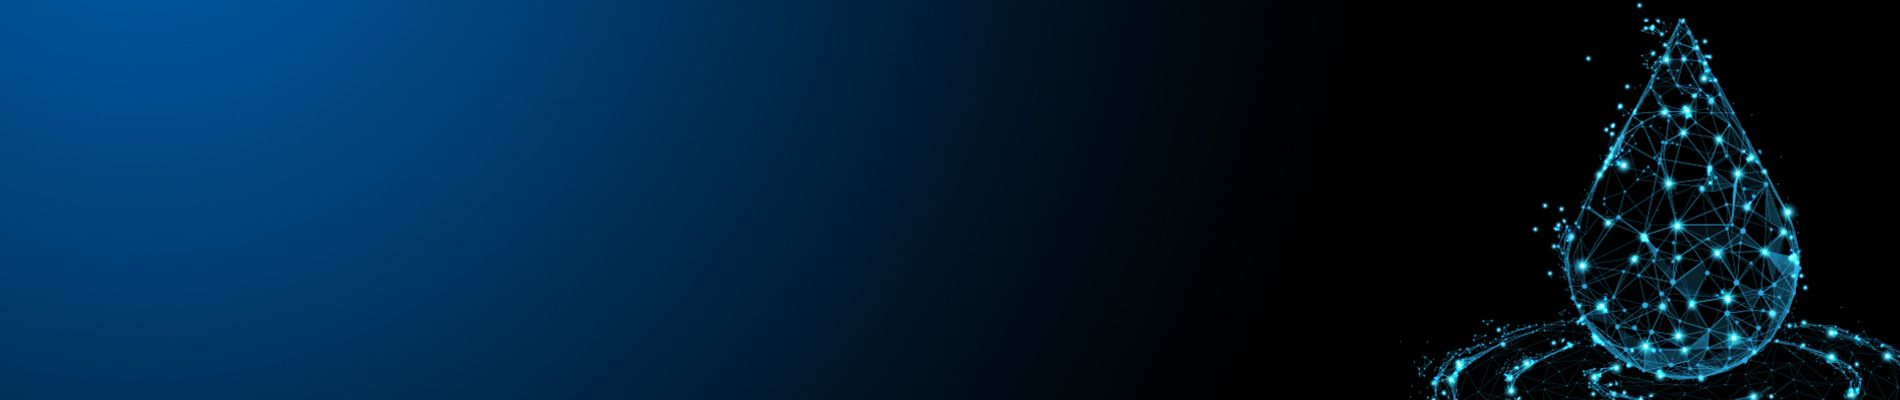

## Acea Smart Water Analytics

Climate change is certainly one of the greatest threat to humanity. Temperature changes undoubtedly worry us, and water scarcity which is not a severe problem at this point of time through out the world, but recent years has shown how the important the problem of water and what kind of challenges can be expected in future. As a part of Data Science community we can work to deliver a solution where water availability can be predicted in future and understand what all factors affect the water levels, so that proper planning and water management can be done to avoid the scarcity problem.
Here, as there are different kinds of waterbodies, for each of the waterbodies there and EDA and statistical(Vector Auto Regression Model) and machine learning model(CatBoost using Hyper-opt) is built by doing some feature engineering

As the scope of the problem statement is more focused on understanding the features that affects the dependent variable, lags of the dependent variable was not used in making ML models. For some waterbodies the meteorological factors given had very less relevance for model building, so for them date columns were feature engineered to create features. 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

A dataframe is created with all the waterbodies and their corresponding output columns, to compile the error metrics for each of the model built

In [ ]:
waterbody_df=pd.read_excel("/kaggle/input/acea-water-prediction/datasets_description.ods",sheet_name="Datasets_Description")
waterbody_df.drop("Description",axis=1,inplace=True)
waterbody_df.replace(r'\n',  '', regex=True,inplace=True)
waterbody_df.replace(r' ',  '', regex=True,inplace=True)
waterbody_df=waterbody_df.set_index("Database").apply(lambda x: x.str.split(',').explode()).reset_index()

Relevent columns are added to the dataframe to store the error metrics.

In [ ]:
waterbody_df[["VAR_RMSE","VAR_MAE","Catboost_RMSE","Catboost_MAE"]]=np.nan
waterbody_df

Also created one more dataframe which stores waterbody name and its corresponding dataset path

In [ ]:
waterbody_path= pd.DataFrame(columns = ['waterbody_name',"waterbody_path"])
for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        waterbody_name = filename.split(".")[0]
        waterbody_path = waterbody_path.append({'waterbody_name': waterbody_name,"waterbody_path":os.path.join(dirname, filename) }, ignore_index=True)

waterbody_path.set_index("waterbody_name",inplace=True)
waterbody_path

Imporitng all the required packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot 
from datetime import datetime, date
from matplotlib.pyplot import figure
import missingno as msno


from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#VAR
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import sklearn
import catboost
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

#plt.style.use('bmh')

# Content

1. **Aquifer Petrignano**
   * About the waterbody
   * Data Preprocessing
   * EDA and Visualization
   * Statistical approach
   * Feature engineering
   * Machine Learning approach
   
   
1. **Lake Bilancino**

   * About the waterbody
   * Data Preprocessing
   * EDA and Visualization
   * Statistical approach
   * Feature engineering
   * Machine Learning approach
   
   
1. **Water Spring Amiata**

   * About the waterbody
   * Data Preprocessing
   * EDA and Visualization
   * Statistical approach
   * Feature engineering
   * Machine Learning approach


1. **River Arno**

   * About the waterbody
   * Data Preprocessing
   * EDA and Visualization
   * Statistical approach
   * Feature engineering
   * Machine Learning approach


1. **Water Spring Lupa**

   * About the waterbody
   * Data Preprocessing
   * EDA and Visualization
   * Statistical approach
   * Feature engineering
   * Machine Learning approach


1. **Water Spring Madonna Ci Canneto**

   * About the waterbody
   * Data Preprocessing
   * EDA and Visualization
   * Statistical approach
   * Feature engineering
   * Machine Learning approach
   
1. **Aquifer Doganella**

   * About the waterbody
   * Data Preprocessing
   * EDA and Visualization
   * Statistical approach
   * Feature engineering
   * Machine Learning approach


1. **Aquifer Auser**

   * About the waterbody
   * Data Preprocessing
   * EDA and Visualization
   * Statistical approach
   * Feature engineering
   * Machine Learning approach


1. **Aquifer Luco**

   * About the waterbody
   * Data Preprocessing
   * EDA and Visualization
   * Statistical approach
   * Feature engineering
   * Machine Learning approach
       

**Disclaimer**

As there are 9 waterbodies are involved, providing explanation for each of the waterbody would make the notebook very lengthy. So most of the explanation of the approach is covered in the first waterbody itself and functions are created which has been used  for the steps that are repeating , and explanation of those functions are provided as a docstring

**Terminology for feature columns**

1. (feature_name)\_lag\(x) - The xth lag of a feature column
2. (feature_name)\_trend  - Trend component of a feature columns
3. (feature_name)\_seasonal - Seasonal component of a feature columns
4. (effective_(feature_name) - After factoring the particular feature column with temperature,
5. (feature_name)\_cumsum_\(x) - The cumulative mean of a feature value for x no. of past days.
6. (feature_name)\_lag\(x)cumsum_\(y) - The cumulative mean of a feature value for y no. of past days from xth lag of the same feature column.
7. (feature_name)\_lag\(x)_trend - Trend component of the xth lag of feature column

In this way, there are various combinations of feature names are present, so as to give a clear picture of what part of a column effects the output variable properly.

<a id="section-three"></a>
<h2 style='color:WHITE; background:#50A8E3; border:2px solid #50A8E3'><center>AQUIFIER PETRIGNANO</center></h2> 

# About 

The wells field of the alluvial plain between Ospedalicchio di Bastia Umbra and Petrignano is fed by three underground aquifers separated by low permeability septa. The aquifer can be considered a water table groundwater and is also fed by the Chiascio river. The groundwater levels are influenced by the following parameters: rainfall, depth to groundwater, temperatures and drainage volumes, level of the Chiascio river.

# Data Preprocessing

Reading Petrignano data, into a pandas dataframe.
Here are the last 5 rows of the dataframe.

In [ ]:
waterbody_name = "Aquifer_Petrignano"

In [ ]:
waterbody = pd.read_csv(waterbody_path.loc[waterbody_name,"waterbody_path"])
waterbody.tail(5)

**Missing Values**

In [ ]:
msno.matrix(waterbody)

The data for some columns are missing in initial records. Hence, it is better to drop the rows untill some columns have NULL values

In [ ]:
#Setting date column as index

waterbody['Date']=pd.to_datetime(waterbody['Date'],format='%d/%m/%Y')
waterbody.set_index('Date',inplace=True)

**Truncating Dataframe**

In [ ]:
def find_start_position(df1):
    '''
    This function finds the location of the cell untill which a perticular column start to have real values. 
    It stores this data into an array and slices the dataframe based on the location of cell with maximum NaN value at start for a column.
    '''
    
    df = df1.copy()

    # Dropping the columns which do not have null values at the start

    col_drop = []
    col_names = pd.Series(df.columns)
    for j in range(len(df.columns)):
        if pd.notnull(df.iloc[0,j]):
            col_drop.append(j)
    for i in col_drop:
        df.drop(labels = col_names[i],axis=1,inplace=True)

    # Finding the position in the dataframe which we will be considered for further analysis

    pos = []
    for j in range(len(col_names)-len(col_drop)):
        for i in range(len(df)):
            if pd.notnull(df.iloc[i,j]):
                pos.append(i)
                break
                
    # returning the new dataset 
    return df1[max(pos):]



In [ ]:
waterbody = find_start_position(waterbody)
msno.matrix(waterbody)

A check for all the simultanious rows to be continous dates, in a sequence

In [ ]:
def date_continuity(waterbody):
    
    '''
    Checks whether the dates are continous and the difference in dates should be one, so that we can know, if at all any rows are missing.
    '''
    
    date_check=pd.DataFrame()
    date_check['real']=waterbody.index
    date_check['shifted']=date_check['real'].shift(-1)
    date_check['dist']=date_check['real']-date_check['shifted']
    print(date_check['dist'].value_counts())
    



In [ ]:
date_continuity(waterbody)

As this is a multi-dataset problem, there are lot of columns involved and each of the columns has different names. So listing them categorically based on the type of column will make our work easy.

In [ ]:
def categorical_list(df):
    
    '''
    Based on the string groups the name of the columns into different categorical lists and return these lists as an output.
    '''
        
    groundwater_col_list = [s for s in df.columns if "Depth_to_Groundwater" in s]
    rainfall_col_list = [s for s in df.columns if "Rainfall" in s]
    temperature_col_list=[s for s in df.columns if "Temperature" in s]
    volume_col_list = [s for s in df.columns if "Volume" in s]
    hydrometry_col_list = [s for s in df.columns if "Hydrometry" in s]
    flow_rate_col_list = [s for s in df.columns if "Flow" in s]
    lake_level_col_list = [s for s in df.columns if "Level" in s]
    return groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list


Now lets fix all the missing value present in between the records, But before that lets visualize our data

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)

Depth_to_Groundwater_P24 and Depth_to_Groundwater_P25 are completely correlated, and therefore averaged values can be used. There is a strange dip in monthly temperatures for Temperature_Petrignano in 2015. This is most likely due to missing values since, in general, the dynamics are almost identical to Temperature_Bastia_Umbra. The same dip is seen in the Hydrometry metric.

Most of all (judging by the graphs) Depth_to_Groundwater_P24 and Depth_to_Groundwater_P25 are affected by the drainage volume (Volume_C10).

In [ ]:
def violin_plots(df):
    row_num=(len(df.columns)//3)+1
    fig, ax = pyplot.subplots(nrows=row_num,ncols=3,figsize =(18, row_num*6))   
    ax1=ax.flatten()
    for i,t in enumerate(df.columns):
        sns.violinplot(ax=ax1[i],y=t, data=df) 

In [ ]:
violin_plots(waterbody)

There are erronious values present in between the records in some columns, lets remove those data by outlier detection for the columns where the outliers make no sense such as Hydrometry and Volume's columns.

But for rainfall the irregularity in data is expected as some days it can rain havily and some days it wont.

In [ ]:
def removeoutlier(group,stds):
    
    '''
    Here group stands for the column values and stds stands for standard deviation.
    If the absolute value od data points are greater than given threshold standard deviation then it is replaced by NaN value
    '''
    
    group[np.abs(group - group.mean()) > stds * group.std()]=np.nan

In [ ]:
col_names = waterbody.columns

#Removing outlier for columns other than Rainfall
for col in col_names[~col_names.str.contains('Rainfall',regex=True)]:
    removeoutlier(waterbody[col],3)

But, there is a catch here, for **Temperature_Petrignano**, we see the temperature being continously zero for four months which is not practically possible

In [ ]:
waterbody[['Temperature_Bastia_Umbra','Temperature_Petrignano']].plot.line(figsize=(18,5))

Let's manually change the value to NAN, which later can be fixed by using Bastia_Umbra's temperature as they have very high correlation

In [ ]:
waterbody.loc[((waterbody.index>=datetime(2015,1,1)) & (waterbody.index<=datetime(2016,1,1)) & (waterbody[col_names[4]]==0)),col_names[4]]=np.nan

Lets now observe the percentage of missing values 

In [ ]:
def missing_prcnt(df):
    
    
    '''
    Stores the sum of missing values in an array known as total, and percentage is calculated by dividing the sum with the no. of rows.
    These two columns are concatenated and those rows are shown as an output where the percentage is greater than zero
    '''
    
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    # We are going to consider just the feaures that have at least 1 missing value
    return missing_data[missing_data['Percent'] > 0]


In [ ]:
missing_data=missing_prcnt(waterbody)
missing_data

Yearly missing percentage, gives us an idea about how close the missing values are present and gives an estimate of the technique that can be used to fix there missing values, whether to use interpolation or any better imputation technique.

In [ ]:
def missing_prcnt_yearly(missing_data,df1):
    
    '''
    Groups by the data yearly, and finds the percentage of missing values year wise.
    Also gives colour gradient based on the missing values present each year.
    '''
        
    df=df1.copy()
    df['Date'] = pd.to_datetime(df.index, format = '%d/%m/%Y')

    df['year'] = df['Date'].dt.year

    nan_by_year = pd.DataFrame(index = df['year'].unique())

    for col in missing_data.index.tolist():
        count = df[col].isnull().groupby(df['year']).sum().astype(int).reset_index(name='count')
        nan_by_year[col] = count['count'].values
    nan_by_year

    figure(figsize= (22, 10))
    missing_percent = (nan_by_year/365)*100
    sns.heatmap(missing_percent, annot = True,  linewidths=.5, cmap = 'rocket_r')

    ax = plt.gca()
    ax.set_ylabel("Year", fontsize = 25)
    ax.set_xlabel("Variable", fontsize = 25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18, rotation=0)

    ax.set_title("% of Missing values per year", fontsize = 35, pad = 25)

    #plt.savefig('Petrignano_missing.png', bbox_inches='tight')



In [ ]:
missing_prcnt_yearly(missing_data=missing_data,df1=waterbody)

Listing each of the columns in their corresponding categorical list

In [ ]:
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)
output_columns = groundwater_col_list

For the columns which has more missing value per year, indicates presence of continous missing values, which can't be simply interpolated as the data filling wont be justifiable as shown below.

In [ ]:
temp = waterbody['Temperature_Petrignano'].copy().rename('Temperature_Petrignano')
temp = temp.to_frame()
temp['Filled by interpolation'] = temp['Temperature_Petrignano'].interpolate(method='linear')
temp.plot.line(y=['Filled by interpolation','Temperature_Petrignano'],figsize=(18,5))

This shows that different methodologies have to be employed in order to fix the high missing value columns.

Let's first interpolate the column which has very less missing values

In [ ]:

def interpolate_df(df,col_no,method='linear'):
    for col in df.columns[col_no]:
        df[col]=df[col].interpolate(method='linear')
        


In [ ]:
interpolate_df(df=waterbody,col_no=[1,2,5])

Using linear regression with Temperature_Bastia_Umbra to fix Temperature_Petrignano

In [ ]:
lr_set=waterbody.filter([col_names[3],col_names[4]],axis=1)
lr_set1=lr_set.dropna()

model=LinearRegression()
X = np.array(lr_set1[col_names[3]]).reshape(-1, 1)
y= np.array(lr_set1[col_names[4]]).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
model.fit(X=X_train,y=y_train)

for i in range(len(waterbody)):
    if np.isnan(waterbody.iloc[i,4]):
        waterbody.iloc[i,4]=model.predict(waterbody.iloc[i,3].reshape(1, -1))[0][0]

In [ ]:
waterbody.plot.line(y=col_names[4],figsize=(18,5))

As Hydrometry has no, columns with which it has good correlation, so lets feature engineer date columns and use [**Iterative Imputer from SK-learn**](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) to fix hydrometry values.

In [ ]:
col_names

In [ ]:
#Creating a new temporary dataframe just for fixing the values of Hydrometry of Chiasco river
temp_df=waterbody.filter([col_names[6]],axis=1).copy()
#Feature engineering date columns
temp_df['Year']=pd.DatetimeIndex(temp_df.index).year
temp_df['month']=pd.DatetimeIndex(temp_df.index).month
temp_df['day']=pd.DatetimeIndex(temp_df.index).day
month_in_year = 12
#Cyclical Features are also encoded, so as to show a continuity in the months like January and December
temp_df['month_sin'] = np.sin(2*np.pi*temp_df.month/month_in_year)
temp_df['month_cos'] = np.cos(2*np.pi*temp_df.month/month_in_year)
temp_df['season'] = temp_df.month%12 // 3 + 1

temp_df['day_of_year'] = pd.DatetimeIndex(temp_df.index).dayofyear
days_in_year = 365.25
temp_df['day_of_year_sin'] = np.sin(2*np.pi*temp_df.day_of_year/days_in_year)
temp_df['day_of_year_cos'] = np.cos(2*np.pi*temp_df.day_of_year/days_in_year)

temp_df['week_of_year'] = pd.DatetimeIndex(temp_df.index).weekofyear
weeks_in_year = 52.1429
temp_df['week_of_year_sin'] = np.sin(2*np.pi*temp_df.week_of_year/weeks_in_year)
temp_df['week_of_year_cos'] = np.cos(2*np.pi*temp_df.week_of_year/weeks_in_year)

Using iterative imputer for the new dataframe created to solve the missing values for hydrometry column.

In [ ]:
X1 = waterbody
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
result_X1[col_names[-1]].plot.line(figsize=(18,3))

waterbody['Hydrometry_Fiume_Chiascio_Petrignano'] = result_X1[col_names[-1]]

# EDA
_Now as the data processing is done, its time for some data analysis and innovates some new features from our data_

For our case dealing with years of data, daily data, that varies everyday is very difficult to comprehend.
So lets create some aggreated dataframes which will give a better understanding of the data,

In [ ]:
annual_resampled_data=waterbody.resample('A').mean()
month_resampled_data=waterbody.resample('M').mean()
week_resampled_data=waterbody.resample('W').mean()
month_groupby=waterbody.groupby([waterbody.index.month_name()], sort=False).mean()

**Yearly trend and seasonality in all columns**

In [ ]:
def yearlytrend_and_seasonality(df):
    
    '''
    Plots yearly plots and seasonal plot for the given dataframe
    '''
    
    fig, axes = plt.subplots(nrows=(len(df.columns)),ncols=2,figsize=(18,2*(len(df.columns))))
    annual_resampled_data.plot(ax = axes[:,0], subplots=True) 
    month_groupby.plot(ax = axes[:,1], subplots=True)
    


In [ ]:
yearlytrend_and_seasonality(waterbody)

In 2012, there was a significant decrease in rainfall that also accompanied by a change in drainage volume. After 2012 up to 2014, with an increase in annual rainfall, the depth of groundwater and drainage volume became less that looks logical. There is no rainfall data for 2008.


In [ ]:
import matplotlib.pyplot as plt


def scatter_colour(df,xx,yy,title_string):
    plt.figure(figsize = (10, 6))
    ax = plt.axes()

    p1=sns.scatterplot(x=xx,y=yy,data=df,hue='Date')
    p1.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

    ax.set_title(title_string)

    for l1 in range(0,df.shape[0]):
         p1.text(df[xx][l1]+0.01, 
                 df[yy][l1], 
                 df.index[l1], 
                 horizontalalignment='left', 
                 size='medium', color='black')
            



In [ ]:
scatter_colour(month_groupby,col_names[-1],col_names[1],"Petrignano: Variation of depth of groundwater with Chiascio River")

In [ ]:

def yearwise_lineplots(df,colname):
    year_array = pd.Series(df.index.year.values).unique()
    plt.figure(figsize = (10, 6))
    plt.title("Yearwise distribuation of "+ colname)
    m=60
    if 'Rainfall' in colname:
        m=150
        
    plt.xlabel("time")
    plt.ylabel(str(m)+"-day rolling average")
    
    colors = sns.color_palette("rocket_r", n_colors=len(year_array))  # get a number of colors
    j=0
    for i in year_array:
        
        plt.plot(df[df.index.year == i][colname].reset_index(drop=True).rolling(m).mean(),label=i,color=colors[j])
        j=j+1
        
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if 'Rainfall' in colname:
        print('For Rainfall columns the moving average is taken to be 150,ignore legend')




In [ ]:
yearwise_lineplots(waterbody,col_names[2])
# for col in col_names:
#     yearwise_lineplots(waterbody,col)

# VAR modeling 


We know that water cycles runs throughout the environment, lets see how each of the given features are bi-directionally related, to each other

**Granger Causality test**  https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.
In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

The below code implements the Granger’s Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=14
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    warnings.filterwarnings("ignore")
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [ ]:
grangers_causation_matrix(waterbody, variables = waterbody.columns) 

The zero values in Depth to groundwater signifies all the varaibels are useful for prediction.

**Train- test split**

In [ ]:
#No. of observation we would like to predict

nobs = 182

#Selecting top 1500 points to capture the recency in the data

if len(waterbody)>1500:
    model_df = waterbody[-1500:]
else:
    model_df = waterbody[:]
model_df_train, model_df_test = model_df[0:-nobs], model_df[-nobs:]

**Why we should use recent data for analysis?**

In order to capture the recent trends and relationship among the variable columns present we discard the old data and only focus on the recent 1500 data points if more data points are present. Thus, making our analysis and prediction relevant to recent relationships.

**Necessity of stationarity**

Since the VAR model requires the time series to forecast to be stationary, it is customary to check all the time series in the system for stationarity.
A stationary time series is one whose characteristics like mean and variance does not change over time.

By the way, if a series is found to be non-stationary, we make it stationary by differencing the series once and repeat the test again until it becomes stationary.

Since, differencing reduces the length of the series by 1 and since all the time series has to be of the same length, we need to difference all the series in the system if you choose to difference at all.

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    
    """Perform ADFuller to test for Stationarity of given series and print report"""
    
    r = adfuller(series, autolag='AIC')
    
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    if p_value <= signif:
        x =0
    else:
        x = 1
        
    return x

In [ ]:
# ADF Test on each column
def differencing_till_stationary(model_df_train):  
    
    '''
    Based on the ADF tests, differences the data untill it gets stationary. Hence, returns the differenced dataframe and also no. of differences done.
    This no. of differences variable is again used while inverting the dataframe
    '''
    
    no_of_differencing = 0
    for i in range(0,10):
        flag =0
        
        for name, column in model_df_train.iteritems():
            x = adfuller_test(column, name=column.name)
            flag = flag + x


        if flag != 0:
            model_df_train = model_df_train.diff().dropna()
            no_of_differencing = no_of_differencing + 1
            
        elif flag == 0:
            break

        i = i+1
    return model_df_train, no_of_differencing




In [ ]:
model_df_train_differenced,no_of_differencing=differencing_till_stationary(model_df_train)

Now as all series are made stationary, lets start modelling.

In [ ]:
#Creating a model for VAR

model = VAR(model_df_train_differenced)

#Optimizing with the best lag

result = model.fit(maxlags=30, ic='aic')
#print('lag - {}'.format(result.k_ar))

#Storing the best lag in a variable

lag = result.k_ar

#Again modelling using the best lag

model_lag = VAR(model_df_train_differenced)
result_lag = model_lag.fit(lag)
result_lag.summary()

forecast_input = model_df_train_differenced.values[-lag:]

# Forecast
fc = result_lag.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=model_df.index[-nobs:], columns=model_df.columns)

As differencing is done on the data, inverse transformation has to be done, so as to check our predictions and finding the error metrics

In [ ]:
def invert_transformation(df_train, df_forecast,no_of_differencing):
    
    """Revert back the differencing to get the forecast to original scale."""
    
    df_fc = df_forecast.copy()
    columns = df_train.columns
    if no_of_differencing != 0:
        for col in columns:        
           # Roll back 2nd Diff
            if no_of_differencing==2:
                df_fc[str(col)] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)].cumsum()
          #  Roll back 1st Diff
            df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    else:
        df_fc[str(col)+'_forecast'] = df_fc[str(col)]
    return df_fc

In [ ]:
forecasted_df= invert_transformation(model_df,df_forecast, no_of_differencing)


In [ ]:
def predict_store_VAR(forecasted_df,model_df_test,output_columns):
    
    '''This function stores the required error metrics in their corresponding cells in waterbody_df.'''
    for output_col in output_columns:
        y_predicted = forecasted_df[str(output_col)+'_forecast']
        y_test =model_df_test[str(output_col)]
        waterbody_df.loc[(waterbody_df.Database==waterbody_name)& (waterbody_df.Output==output_col),"VAR_RMSE"] = mean_squared_error(y_predicted, y_test)
        print(output_col+" RMSE: "+str(mean_squared_error(y_predicted, y_test)))
        waterbody_df.loc[(waterbody_df.Database==waterbody_name)& (waterbody_df.Output==output_col),"VAR_MAE"] = mean_absolute_error(y_predicted, y_test)
        print(output_col+" MAE: "+str(mean_absolute_error(y_predicted, y_test)))

In [ ]:
predict_store_VAR(forecasted_df,model_df_test,output_columns)

# Feature Engineering

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

Here we can see there is a very high correlation in temperature in both the places, instead of using both the columns we can reduce the columns using PCA

In [ ]:

def Principal_Component_Analysis(df,prefix_string,org_db):
    
    '''Returns a dataframe with the replaced columns that captures 90% of the data of the given list of columns as a list as an input.'''
    scaler = StandardScaler().fit(df)
    X_std = scaler.transform(df)
   
    k = len(df.columns)
    pca = PCA(n_components = k)
    pca.fit(X_std)
    x_pca = pca.transform(X_std)
    v = pca.explained_variance_ratio_.round(2)
   
    # setting variance capture limit as 90%
    var_limit = 0.90
    cummulative = np.cumsum(v)
    for i in range(len(cummulative)):
        if cummulative[i]>=var_limit:
            PCA_comp = i+1
            break
   
    pca = PCA(n_components = PCA_comp).fit(X_std)
    X = pca.transform(X_std)
    columns = []
    for i in range(0,PCA_comp):
        columns.append(prefix_string+"_"+str(i))
    pf = pd.DataFrame(X, columns=columns,index=df.index)
    org_db.drop(df.columns, axis = 1,inplace=True)
    org_db = pd.concat([org_db,pf],axis=1)
    return org_db

In [ ]:
prefix_string = "Temperature"

waterbody=Principal_Component_Analysis(df=waterbody[temperature_col_list],prefix_string=prefix_string,org_db=waterbody)
#updating col_list
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)
#re_assgining
col_names = waterbody.columns

**Infilteration takes time**

As the waterbodyis an aquifier, it takes time to sip in through the rocks to replenish the waterlevel, So, lags of rainfall and River Chiasco's hydrometry can be taken into consideration for finding the groundwater level.

In [ ]:
def create_lags(df,col_list):
    for col in col_list:
        df[col+'_lag7']=df[col].shift(7)
        df[col+'_lag14']=df[col].shift(14)
        df[col+'_lag30']=df[col].shift(30)
        df[col+'_lag90']=df[col].shift(90)

In [ ]:
create_lags(waterbody,rainfall_col_list)
create_lags(waterbody,hydrometry_col_list)
#create_lags(waterbody,groundwater_col_list)

**Wait a minute..,infiltration happens everyday** 

The groundwater level will be replinished not only by single day's rainfall in rainfall but it will happen cummilitvely. Just for the sake of simplicity lets consider a cummulative mean of all the rainfall for past 7,30,60 days. And same repeats for Hydrometry.

In [ ]:
def cumsum_column_add(df,column_list,lagging_array=[7,30,60]):
        
    for col in column_list:
        
        for lag_end in lagging_array:
            temp3=pd.DataFrame()
            temp2=pd.DataFrame()
            for lag in range(1,lag_end):
                temp2[col+'lag_'+str(lag)]=df[col].shift(lag)
                
            temp3[col+'_cumsum_'+str(lag_end)]=temp2.mean(numeric_only=True, axis=1)
            df = pd.concat([df,temp3],axis=1)
            df.dropna(inplace=True)
    return df

In [ ]:
#waterbody =cumsum_column_add(waterbody,rainfall_col_list)
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)
waterbody = cumsum_column_add(waterbody,['Rainfall_Bastia_Umbra_lag7'])
waterbody = cumsum_column_add(waterbody,['Hydrometry_Fiume_Chiascio_Petrignano_lag7'])


**Effect of evaporation**

We know that, all the water from rainfall and hydrometry donot goes to the aquifer, some are consumed by vegetation. But sometimes, due to high temperature most of the water gets evaporated and hence donot contribute to the aquifier infilitration. So, in order to consider the effect of evporation, we can factor the rainfall based on the temperature

In [ ]:
def effect_of_evaporation(df,temp_col,eva_affected_list):
    for col in eva_affected_list:
        df['Temp_max_byyear']=df.groupby(df.index.year)[temp_col].transform(max)
        df['Temp_min_byyear']=df.groupby(df.index.year)[temp_col].transform(min)
        df['eva_factor']=(df[temp_col]-df['Temp_min_byyear'])/(df['Temp_max_byyear']-df['Temp_min_byyear'])
        df['effective_'+col]=df[col]*(1-df['eva_factor'])
        df.drop(['Temp_max_byyear','Temp_min_byyear','eva_factor'],axis=1,inplace=True)

In [ ]:
effect_of_evaporation(waterbody,temperature_col_list[0],['Rainfall_Bastia_Umbra_lag7'])
#effect_of_evaporation(waterbody,temperature_col_list[0],['Hydrometry_Fiume_Chiascio_Petrignano_lag7'])

**Series = Trend + Seasonality + Residual**

A series consist of trend, seasonality and residuals, decomoposing it can help in capuring the relevent columns, and ignore the residuals so as to get a better overview of what component of a time series most affects the dependent variable.

In [ ]:
def get_decomp_list(df,output_columns):
    col_list = waterbody.columns.tolist()
    for col in output_columns:
        col_list.remove(col)
    return col_list

In [ ]:
decomp_list = get_decomp_list(df=waterbody,output_columns=output_columns)

In [ ]:
def decompose_store_trend(df,col_list):
    for col in col_list:
        result = seasonal_decompose(df[col], model='add', period=182)
        df[col+'_trend']=result.trend
        df[col+'_seasonal']=result.seasonal
        df.drop(col,inplace=True,axis=1)


In [ ]:
decompose_store_trend(waterbody,decomp_list)

In [ ]:
def columns_greaterthancorr(df,output_column,columns,threshold=0.05):
    '''To reduce the dimensionality, and unnecessary columns, this filter is used to limit our no. of features'''
    cfeature = []
    for col in columns:
        corr = df[output_column].corr(df[col])
        if abs(corr) > threshold:
            cfeature.append(col)
    return cfeature

In [ ]:
def get_catboost_params(space):
    '''Stores all the parameters in a dictionary.'''
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    params['border_count'] = space['border_count']
    #params['rsm'] = space['rsm']
    return params

**Comprehend black box**

To understand how each of the feature, influences our output variable and how important is that feature. We will be using SHAP for it.

In [ ]:
import shap


def ABS_SHAP(adv_pool,model,df,output_col):
    #import matplotlib as plt
    # Make a copy of the input data
    explainer = shap.TreeExplainer(model)
    df_shap = explainer.shap_values(adv_pool)
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy() #.reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,0.5*len(feature_list)),legend=False)
    ax.set_xlabel("SHAP Value for "+output_col+" (Red = Positive Impact)")
    


In [ ]:
def testvsmodel(y_test,pred,output_col):
    fig, ax = plt.subplots(figsize=(15, 4))
    idxs = np.array(range(len(pred))) + 1
    ax.plot(idxs, np.array(y_test), linestyle="solid", label='Data')
    ax.plot(idxs, np.array(pred), linestyle="dashed", label='Model')
    legend = ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', shadow=True, borderaxespad=0, fontsize=16)
    plt.title("Comparison of data and prediction results Catboost: "+output_col, fontsize=18)

In [ ]:
obj_call_count =0
cur_best_loss =np.inf

In [ ]:
def mycatboost(waterbody,output_col,output_columns,putDate = False):
    
    # storing the features in a list, which are other than the output columns
    features = list(set(waterbody.columns.tolist()).difference(set(output_columns)))
    features = columns_greaterthancorr(waterbody,output_col,features)

    #creating date features if putDate is true
    if putDate == True:
        waterbody['Date_Year']=pd.DatetimeIndex(waterbody.index).year
        waterbody['Date_month']=pd.DatetimeIndex(waterbody.index).month

        month_in_year = 12
        waterbody['Date_month_sin'] = np.sin(2*np.pi*waterbody.Date_month/month_in_year)
        waterbody['Date_month_cos'] = np.cos(2*np.pi*waterbody.Date_month/month_in_year)
        waterbody['Date_season'] = waterbody.Date_month%12 // 3 + 1

    #Only selecting the lag values, so as to understand the relationships of lags of meteorological factor, which will give an hollistic view in a way were we can understand how the output variable behaves based on present meteorological values.
    features = [s for s in features if 'lag'   in s]
    #If date columns are present will be appended to feature list
    features.extend([s for s in waterbody.columns if 'Date_'   in s])

    set1=waterbody.dropna()
    #Selecting only the recent data
    if len(set1)>1500:
        set2 = set1[-1500:] 
    else:
        set2 = set1
        
    X1 = set2[features]
    
    #standardizing all features that will be used for training
    scaler = StandardScaler().fit(X1)
    scaled_df = scaler.transform(X1)
    X=pd.DataFrame(scaled_df, columns=X1.columns)
    y = set2[output_col]

    #Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

    #Setting up hyper-opt parameters
    N_HYPEROPT_PROBES = 60
    HYPEROPT_ALGO = tpe.suggest
    colorama.init()

    D_train = catboost.Pool(X_train, y_train)
    D_test = catboost.Pool(X_test, y_test)

    #Defining a function for parameter tunning in hyperopt
    def objective(space):

        global obj_call_count
        global cur_best_loss
        obj_call_count += 1

        #print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

        params = get_catboost_params(space)

        sorted_params = sorted(space.items(), key=lambda z: z[0])
        params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
        #print('Params: {}'.format(params_str) )

        model = catboost.CatBoostRegressor(iterations=5000,
                                            learning_rate=params['learning_rate'],
                                            depth=int(params['depth']),
                                            use_best_model=True,
    #                                         task_type="GPU",
                                            eval_metric='RMSE',
                                            l2_leaf_reg=params['l2_leaf_reg'],
                                            early_stopping_rounds=800,
                                            od_type="Iter",
                                            border_count=int(params['border_count']),
                                            verbose=False
                                            )
        model.fit(D_train, eval_set=D_test, verbose=False)
        nb_trees = model.tree_count_

        #print('nb_trees={}'.format(nb_trees))

        y_pred = model.predict(D_test.get_features())

        test_loss = sklearn.metrics.mean_squared_error(y_pred, y_test)
        #acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
        #auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

        #log_writer.write('loss={:<7.5f}  Params:{} nb_trees={}\n'.format(test_loss,nb_trees ))
        #log_writer.flush()

        if test_loss<cur_best_loss:
            cur_best_loss = test_loss
            #print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


        return{'loss':test_loss, 'status': STATUS_OK }

    #Defining the space of hyperparameters
    space = {
            'depth': hp.quniform("depth", 1, 6, 1),
            'border_count': hp.uniform ('border_count', 32, 200),
            'learning_rate': hp.loguniform('learning_rate', -4.0, -1),
            'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 6),
           }

    trials = Trials()
    #hyperparameter tuning
    best = hyperopt.fmin(fn=objective,
                         space=space,
                         algo=HYPEROPT_ALGO,
                         max_evals=N_HYPEROPT_PROBES,
                         trials=trials,
                         verbose=False)
    print('-'*50)
    print('The best params for '+output_col+' :')
    print( best )
    print('\n\n')

    #resetting the border count
    best.update({'border_count': int(best['border_count'])})
    #Creating the best model
    model = catboost.CatBoostRegressor(iterations=2000,
                                        use_best_model=True,
    #                                     task_type="GPU",
                                        eval_metric='RMSE',
                                        early_stopping_rounds=500,
                                        od_type="Iter",
                                        verbose=2000,
                                        **best
                                        )

    model.fit(D_train,eval_set=D_test,verbose=2000) 

    #Feature importance
    ABS_SHAP(D_train,model,X_train,output_col) 

    pred = model.predict(X_test)
    pred = np.array(pred)
    #Plotting test set and prediciton
    testvsmodel(y_test,pred,output_col)
    
    #Stroing the error metrics
    waterbody_df.loc[(waterbody_df.Database==waterbody_name)& (waterbody_df.Output==output_col),"Catboost_RMSE"] = mean_squared_error(y_test, pred)
    waterbody_df.loc[(waterbody_df.Database==waterbody_name)& (waterbody_df.Output==output_col),"Catboost_MAE"] = mean_absolute_error(y_test, pred)

    
    print('-----'+output_col+'-----')
    print("RMSE: "+str(mean_squared_error(y_test, pred)))
    print("MAE: "+ str(mean_absolute_error(y_test, pred)))

Calling mycatboost for ML modelling

In [ ]:
for output_col in output_columns:
    mycatboost(waterbody,output_col,output_columns)

By observation, from the feature importance charts we can say that, Chiasco water level trend component  and Rainfall for Bastia Umbra's trend component and effective rainfall has a major and positive impact on the depth to groundwater for petrignano aquifer.

In [ ]:
waterbody_df

<a id="section-three"></a>
<h2 style='color:WHITE; background:#50A8E3; border:2px solid #50A8E3'><center>LAKE BILANCINO</center></h2> 

# About

Bilancino lake is an artificial lake located in the municipality of Barberino di Mugello (about 50 km from Florence). It is used to refill the Arno river during the summer months. Indeed, during the winter months, the lake is filled up and then, during the summer months, the water of the lake is poured into the Arno river.

In [ ]:
waterbody_name = "Lake_Bilancino"

In [ ]:
waterbody = pd.read_csv(waterbody_path.loc[waterbody_name,"waterbody_path"])
waterbody.tail(5)

# Data Prepocessing

**Missing Values**

In [ ]:
msno.matrix(waterbody)

The data for some columns are missing in initial records. Hence, it is better to drop the rows untill some columns have NULL values

In [ ]:
#Setting date column as index

waterbody['Date']=pd.to_datetime(waterbody['Date'],format='%d/%m/%Y')
waterbody.set_index('Date',inplace=True)

**Truncating Dataframe**

In [ ]:
waterbody = find_start_position(waterbody)
msno.matrix(waterbody)

A check for all the simultanious rows to be continous dates, in a sequence

In [ ]:
date_continuity(waterbody)

Now lets fix all the missing value present in between the records, But before that lets visualize our data

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)

In [ ]:
violin_plots(waterbody)

There are erronious values present in between the records in some columns, lets remove those data by outlier detection for the columns where the outliers make no sense such as Hydrometry and Volume's columns.

But for rainfall the irregularity in data is expected as some days it can rain havily and some days it wont.

In [ ]:
col_names = waterbody.columns

#Removing outlier for columns other than Rainfall
for col in col_names[~col_names.str.contains('Rainfall',regex=True)]:
    removeoutlier(waterbody[col],3)

Lets now observe the percentage of missing values 

In [ ]:
missing_data=missing_prcnt(waterbody)
missing_data

In [ ]:
missing_prcnt_yearly(missing_data=missing_data,df1=waterbody)

Lets interpolate the columns as it has very less missing values

In [ ]:
interpolate_df(df=waterbody,col_no=[-1])

# EDA 
_Now as the data processing is done, its time for some data analysis and innovates some new features from our data_

For our case dealing with years of data, daily data, that varies everyday is very difficult to comprehend.
So lets create some aggreated dataframes which will give a better understanding of the data,

In [ ]:
annual_resampled_data=waterbody.resample('A').mean()
month_resampled_data=waterbody.resample('M').mean()
week_resampled_data=waterbody.resample('W').mean()
month_groupby=waterbody.groupby([waterbody.index.month_name()], sort=False).mean()

**Yearly trend and seasonality in all columns**

In [ ]:
yearlytrend_and_seasonality(waterbody)

In [ ]:
scatter_colour(month_groupby,col_names[-1],col_names[1],"Luco: Variation of Flow rate with rainfall")

In [ ]:
yearwise_lineplots(waterbody,col_names[-2])
# for col in col_names:
#     yearwise_lineplots(waterbody,col)

# VAR modeling 


We know that water cycles throughout the environemnt, lets see how each of the given features are bi-directionally related, to each other

In [ ]:
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)

output_columns = flow_rate_col_list+lake_level_col_list

In [ ]:
grangers_causation_matrix(waterbody, variables = waterbody.columns) 

The zero values in Depth to groundwater signifies all the varaibels are useful for prediction.

**Train- test split**

In [ ]:
nobs = 182
if len(waterbody)>1500:
    model_df = waterbody[-1500:]
else:
    model_df = waterbody[:]
model_df_train, model_df_test = model_df[0:-nobs], model_df[-nobs:]

# # Check size
# print(model_df_train.shape) 
# print(model_df_test.shape)  

Since the VAR model requires the time series to forecast to be stationary, it is customary to check all the time series in the system for stationarity.
A stationary time series is one whose characteristics like mean and variance does not change over time.

By the way, if a series is found to be non-stationary, we make it stationary by differencing the series once and repeat the test again until it becomes stationary.

Since, differencing reduces the length of the series by 1 and since all the time series has to be of the same length, we need to difference all the series in the system if you choose to difference at all.

Differencing the data untill it achieves stationarity

In [ ]:
model_df_train_differenced,no_of_differencing=differencing_till_stationary(model_df_train)

Modelling and forecasting for the no. of observations

In [ ]:
model = VAR(model_df_train_differenced)
result = model.fit(maxlags=30, ic='aic')
#print('lag - {}'.format(result.k_ar))
lag = result.k_ar

model_lag = VAR(model_df_train_differenced)
result_lag = model_lag.fit(lag)
result_lag.summary()

forecast_input = model_df_train_differenced.values[-lag:]



# Forecast
fc = result_lag.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=model_df.index[-nobs:], columns=model_df.columns)

Inverting the transformation done on the data

In [ ]:
forecasted_df= invert_transformation(model_df,df_forecast, no_of_differencing)

In [ ]:
predict_store_VAR(forecasted_df,model_df_test,output_columns)

# Feature Engineering

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

Here we can see there is a very high correlation in rainfall columns instead of using all of them we can reduce the dimensionality by doing PCA for all rainfall columns

In [ ]:
prefix_string = "Rainfall"

waterbody=Principal_Component_Analysis(df=waterbody[rainfall_col_list],prefix_string=prefix_string,org_db=waterbody)

#updating col_list
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)

#re_assgining
col_names = waterbody.columns#

**Infilteration takes time**

As the waterbodyis an aquifier, it takes time to sip in through the rocks to replenish the waterlevel, So, lags of rainfall and River Chiasco's hydrometry can be taken into consideration for finding the groundwater level.

In [ ]:
create_lags(waterbody,rainfall_col_list)
#create_lags(waterbody,lake_level_col_list)
#create_lags(waterbody,flow_rate_col_list)

In [ ]:
waterbody.columns

**Wait a minute..,infiltration happens everyday** 

The groundwater level will be replinished not only by single day's rainfall in rainfall but it will happen cummilitvely. Just for the sake of simplicity lets consider a cummulative mean of all the rainfall for past 7,30,60 days. And same repeats for Hydrometry.

In [ ]:
#waterbody =cumsum_column_add(waterbody,rainfall_col_list)
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)
waterbody = cumsum_column_add(waterbody,['Rainfall_0_lag7'])
#waterbody = cumsum_column_add(waterbody,['Hydrometry_Fiume_Chiascio_Petrignano_lag7'])


**Effect of evaporation**

We know that, all the water from rainfall and hydrometry donot goes to the aquifer, some are consumed by vegetation. But sometimes, due to high temperature most of the water gets evaporated and hence donot contribute to the aquifier infilitration. So, in order to consider the effect of evporation, we can factor the rainfall based on the temperature

In [ ]:
effect_of_evaporation(waterbody,temperature_col_list[0],['Rainfall_0_lag7'])
#effect_of_evaporation(waterbody,temperature_col_list[0],['Hydrometry_Fiume_Chiascio_Petrignano_lag7'])

**Series = Trend + Seasonality + Residual**

A series consist of trend, seasonality and residuals, decomoposing it can help in capturing only the trend that is being observed over years

In [ ]:
waterbody.columns

In [ ]:
decomp_list = get_decomp_list(df=waterbody,output_columns=output_columns)

In [ ]:
decompose_store_trend(waterbody,decomp_list)

Defining parameters for Catboost

In [ ]:
obj_call_count = 0
cur_best_loss = np.inf
#log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

Running Catboost for all the output columns

In [ ]:
for output_col in output_columns:
    mycatboost(waterbody,output_col,output_columns)

In [ ]:
waterbody_df

<a id="section-three"></a>
<h2 style='color:WHITE; background:#50A8E3; border:2px solid #50A8E3'><center>WATER SPRING AMAIATA</center></h2> 

# About

The Amiata waterbody is composed of a volcanic aquifer not fed by rivers or lakes but fed by meteoric infiltration. This aquifer is accessed through Ermicciolo, Arbure, Bugnano and Galleria Alta water springs. The levels and volumes of the four sources are influenced by the parameters: rainfall, depth to groundwater, hydrometry, temperatures and drainage volumes.

In [ ]:
waterbody_name = "Water_Spring_Amiata"

In [ ]:
waterbody = pd.read_csv(waterbody_path.loc[waterbody_name,"waterbody_path"])
waterbody.tail(5)

# Data Prepocessing

**Missing Values**

In [ ]:
msno.matrix(waterbody)

The data for some columns are missing in initial records. Hence, it is better to drop the rows untill some columns have NULL values

In [ ]:
#Setting date column as index

waterbody['Date']=pd.to_datetime(waterbody['Date'],format='%d/%m/%Y')
waterbody.set_index('Date',inplace=True)

**Truncating Dataframe**

In [ ]:
waterbody = find_start_position(waterbody)
msno.matrix(waterbody)

In [ ]:
date_continuity(waterbody)

Now lets fix all the missing value present in between the records, But before that lets visualize our data

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)

In [ ]:
violin_plots(waterbody)

There are erronious values present in between the records in some columns, lets remove those data by outlier detection for the columns where the outliers make no sense such as Hydrometry and Volume's columns.

But for rainfall the irregularity in data is expected as some days it can rain havily and some days it wont.

In [ ]:
col_names = waterbody.columns

#Removing outlier for columns other than Rainfall
for col in col_names[~col_names.str.contains('Rainfall',regex=True)]:
    removeoutlier(waterbody[col],3)
    print(col)

Lets now observe the percentage of missing values 

In [ ]:
missing_data=missing_prcnt(waterbody)
missing_data

In [ ]:
missing_prcnt_yearly(missing_data=missing_data,df1=waterbody)

Let's first interpolate the column which has very less missing values

In [ ]:
#interpolate_df(df=waterbody,col_no=[-1])

Defining categorical list for each of the columns

In [ ]:
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)
output_columns = flow_rate_col_list

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

Frm observtion we can say that , columns with that perticular group has a very high correlation. Hence iterative imputer, group wise can be useful for filling the missing values


In [ ]:
X1 = waterbody[rainfall_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[rainfall_col_list] = result_X1

In [ ]:
X1 = waterbody[groundwater_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[groundwater_col_list] = result_X1

In [ ]:
X1 = waterbody[temperature_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[temperature_col_list] = result_X1

In [ ]:
X1 = waterbody[flow_rate_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[flow_rate_col_list] = result_X1

# EDA
_Now as the data processing is done, its time for some data analysis and innovates some new features from our data_

For our case dealing with years of data, daily data, that varies everyday is very difficult to comprehend.
So lets create some aggreated dataframes which will give a better understanding of the data,

In [ ]:
annual_resampled_data=waterbody.resample('A').mean()
month_resampled_data=waterbody.resample('M').mean()
week_resampled_data=waterbody.resample('W').mean()
month_groupby=waterbody.groupby([waterbody.index.month_name()], sort=False).mean()

**Yearly trend and seasonality in all columns**

In [ ]:
yearlytrend_and_seasonality(waterbody)

In [ ]:
scatter_colour(month_groupby,col_names[-1],col_names[6],"Luco: Variation of Flow rate with rainfall")

In [ ]:
yearwise_lineplots(waterbody,col_names[-3])
# for col in col_names:
#     yearwise_lineplots(waterbody,col)

# VAR modeling 


We know that water cycles throughout the environemnt, lets see how each of the given features are bi-directionally related, to each other

In [ ]:
grangers_causation_matrix(waterbody, variables = waterbody.columns)

The zero values in Depth to groundwater signifies all the variables are useful for prediction.

**Train- test split**

In [ ]:
nobs = 182
if len(waterbody)>1500:
    model_df = waterbody[-1500:]
else:
    model_df = waterbody[:]
model_df_train, model_df_test = model_df[0:-nobs], model_df[-nobs:]

# # Check size
# print(model_df_train.shape)
# print(model_df_test.shape) 

Differencing the dataset till the data become stationary

In [ ]:
model_df_train_differenced,no_of_differencing=differencing_till_stationary(model_df_train)

Fitting and forecasting the model

In [ ]:
model = VAR(model_df_train_differenced)
result = model.fit(maxlags=30, ic='aic')
#print('lag - {}'.format(result.k_ar))
lag = result.k_ar

model_lag = VAR(model_df_train_differenced)
result_lag = model_lag.fit(lag)
result_lag.summary()

forecast_input = model_df_train_differenced.values[-lag:]

# Forecast
fc = result_lag.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=model_df.index[-nobs:], columns=model_df.columns)

In [ ]:
forecasted_df= invert_transformation(model_df,df_forecast, no_of_differencing)

In [ ]:
predict_store_VAR(forecasted_df,model_df_test,output_columns)

Now as all series are made stationary, lets start modelling.

# Feature Engineering

*Before getting into feature engineering lets create lists of columns of different categories*

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

Here we can see there is a very high correlation in temperature in both the places, instead of using both the columns we can reduce the columns using PCA

In [ ]:
prefix_string = "Rainfall"

waterbody=Principal_Component_Analysis(df=waterbody[rainfall_col_list],prefix_string=prefix_string,org_db=waterbody)

prefix_string = "Depth"

waterbody=Principal_Component_Analysis(df=waterbody[groundwater_col_list],prefix_string=prefix_string,org_db=waterbody)
#updating col_list
prefix_string = "Temperature"

waterbody=Principal_Component_Analysis(df=waterbody[temperature_col_list],prefix_string=prefix_string,org_db=waterbody)

groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)

#re_assgining
col_names = waterbody.columns

**Infilteration takes time**

As the waterbodyis an aquifier, it takes time to sip in through the rocks to replenish the waterlevel, So, lags of rainfall and River Chiasco's hydrometry can be taken into consideration for finding the groundwater level.

In [ ]:
create_lags(waterbody,rainfall_col_list)
create_lags(waterbody,groundwater_col_list)
#create_lags(waterbody,flow_rate_col_list)

In [ ]:
waterbody.columns

**Wait a minute..,infiltration happens everyday** 

The groundwater level will be replinished not only by single day's rainfall in rainfall but it will happen cummilitvely. Just for the sake of simplicity lets consider a cummulative mean of all the rainfall for past 7,30,60 days. And same repeats for Hydrometry.

In [ ]:
#waterbody =cumsum_column_add(waterbody,rainfall_col_list)
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)
waterbody = cumsum_column_add(waterbody,['Rainfall_0_lag7'])
#waterbody = cumsum_column_add(waterbody,['Hydrometry_Fiume_Chiascio_Petrignano_lag7'])


**Effect of evaporation**

We know that, all the water from rainfall and hydrometry donot goes to the aquifer, some are consumed by vegetation. But sometimes, due to high temperature most of the water gets evaporated and hence donot contribute to the aquifier infilitration. So, in order to consider the effect of evporation, we can factor the rainfall based on the temperature

In [ ]:
effect_of_evaporation(waterbody,temperature_col_list[0],['Rainfall_0_lag7'])
#effect_of_evaporation(waterbody,temperature_col_list[0],['Hydrometry_Fiume_Chiascio_Petrignano_lag7'])

**Series = Trend + Seasonality + Residual**

A series consist of trend, seasonality and residuals, decomoposing it can help in capturing only the trend that is being observed over years

In [ ]:
waterbody.columns

In [ ]:
decomp_list = get_decomp_list(df=waterbody,output_columns=output_columns)

In [ ]:
decompose_store_trend(waterbody,decomp_list)

In [ ]:
obj_call_count = 0
cur_best_loss = np.inf
#log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [ ]:
for output_col in output_columns:
    mycatboost(waterbody,output_col,output_columns)

In [ ]:
waterbody_df

<a id="section-three"></a>
<h2 style='color:WHITE; background:#50A8E3; border:2px solid #50A8E3'><center>RIVER ARNO</center></h2> 

# About

The Arno is a river in the Tuscany region of Italy. It is the most important river of central Italy after the Tiber. With a length of 241 kilometres (150 mi), it is the largest river in the region. It has many tributaries: Sieve at 60 kilometres (37 mi) long, Bisenzio at 49 kilometres (30 mi), Ombrone Pistoiese at 47 kilometres (29 mi), and the Era, Elsa, Pesa, and Pescia. The drainage basin amounts to more than 8,200 square kilometres (3,200 sq mi).

The main indicator that will be predicted for the river is hydrometry. The other two features in this dataset are rainfall and temperature. Let's look at their dynamics. Below I'll take some liberties with axes scales in order to make the graphs more visual (somewhere the values will be logarithmized, somewhere they'll be adjusted).

In [ ]:
waterbody_name = "River_Arno"

In [ ]:
waterbody = pd.read_csv(waterbody_path.loc[waterbody_name,"waterbody_path"])
waterbody.tail(5)

# Data Prepocessing

**Missing Values**

In [ ]:
msno.matrix(waterbody)

The data for some columns are missing in initial records. Hence, it is better to drop the rows untill some columns have NULL values

In [ ]:
#Setting date column as index

waterbody['Date']=pd.to_datetime(waterbody['Date'],format='%d/%m/%Y')
waterbody.set_index('Date',inplace=True)

**Truncating Dataframe**

In [ ]:
waterbody = find_start_position(waterbody)
msno.matrix(waterbody)

Dropping some rainfall column, as the recent data on of those columns are unavailable

In [ ]:
waterbody.drop(['Rainfall_Vernio',"Rainfall_Stia","Rainfall_Consuma","Rainfall_Incisa","Rainfall_Montevarchi","Rainfall_S_Savino","Rainfall_Laterina","Rainfall_Bibbiena","Rainfall_Camaldoli"],axis=1,inplace=True)

In [ ]:
date_continuity(waterbody)

Now lets fix all the missing value present in between the records, But before that lets visualize our data

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)

In [ ]:
violin_plots(waterbody)

There are erronious values present in between the records in some columns, lets remove those data by outlier detection for the columns where the outliers make no sense such as Hydrometry and Volume's columns.

But for rainfall the irregularity in data is expected as some days it can rain havily and some days it wont.

In [ ]:
col_names = waterbody.columns

#Removing outlier for columns other than Rainfall
for col in col_names[~col_names.str.contains('Rainfall',regex=True)]:
    removeoutlier(waterbody[col],3)
    

Lets now observe the percentage of missing values 

In [ ]:
missing_data=missing_prcnt(waterbody)
missing_data

In [ ]:
missing_prcnt_yearly(missing_data=missing_data,df1=waterbody)

Let's first interpolate the column which has very less missing values

In [ ]:
#interpolate_df(df=waterbody,col_no=[-1])

Defining categorical list for each of the columns

In [ ]:
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)
output_columns = hydrometry_col_list

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

Frm observtion we can say that , columns with that perticular group has a very high correlation. Hence iterative imputer, group wise can be useful for filling the missing values


In [ ]:
temp_df=waterbody.filter(temperature_col_list,axis=1).copy()
temp_df['Year']=pd.DatetimeIndex(temp_df.index).year
temp_df['month']=pd.DatetimeIndex(temp_df.index).month
temp_df['day']=pd.DatetimeIndex(temp_df.index).day
month_in_year = 12
temp_df['month_sin'] = np.sin(2*np.pi*temp_df.month/month_in_year)
temp_df['month_cos'] = np.cos(2*np.pi*temp_df.month/month_in_year)
temp_df['season'] = temp_df.month%12 // 3 + 1

temp_df['day_of_year'] = pd.DatetimeIndex(temp_df.index).dayofyear
days_in_year = 365.25
temp_df['day_of_year_sin'] = np.sin(2*np.pi*temp_df.day_of_year/days_in_year)
temp_df['day_of_year_cos'] = np.cos(2*np.pi*temp_df.day_of_year/days_in_year)

temp_df['week_of_year'] = pd.DatetimeIndex(temp_df.index).weekofyear
weeks_in_year = 52.1429
temp_df['week_of_year_sin'] = np.sin(2*np.pi*temp_df.week_of_year/weeks_in_year)
temp_df['week_of_year_cos'] = np.cos(2*np.pi*temp_df.week_of_year/weeks_in_year)

In [ ]:
X1 = temp_df
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[temperature_col_list] = result_X1[temperature_col_list]

In [ ]:
interpolate_df(df=waterbody,col_no=[-1])

# EDA
_Now as the data processing is done, its time for some data analysis and innovates some new features from our data_

For our case dealing with years of data, daily data, that varies everyday is very difficult to comprehend.
So lets create some aggreated dataframes which will give a better understanding of the data,

In [ ]:
annual_resampled_data=waterbody.resample('A').mean()
month_resampled_data=waterbody.resample('M').mean()
week_resampled_data=waterbody.resample('W').mean()
month_groupby=waterbody.groupby([waterbody.index.month_name()], sort=False).mean()

**Yearly trend and seasonality in all columns**

In [ ]:
yearlytrend_and_seasonality(waterbody)

In [ ]:
scatter_colour(month_groupby,col_names[6],col_names[1],"Arno: Variation of Flow rate with rainfall")

In [ ]:
yearwise_lineplots(waterbody,col_names[6])
# for col in col_names:
#     yearwise_lineplots(waterbody,col)

In [ ]:
waterbody[col_names[-1]].plot.line(figsize=(18,5))

# VAR modeling 


We know that water cycles throughout the environemnt, lets see how each of the given features are bi-directionally related, to each other

**Granger Causality test**  https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.
In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

The below code implements the Granger’s Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

In [ ]:
grangers_causation_matrix(waterbody, variables = waterbody.columns)

**Train- test split**

In [ ]:
nobs = 182
if len(waterbody)>1500:
    model_df = waterbody[-1500:]
else:
    model_df = waterbody[:]
model_df_train, model_df_test = model_df[0:-nobs], model_df[-nobs:]

# # Check size
# print(model_df_train.shape)
# print(model_df_test.shape) 

Since the VAR model requires the time series to forecast to be stationary, it is customary to check all the time series in the system for stationarity.
A stationary time series is one whose characteristics like mean and variance does not change over time.

By the way, if a series is found to be non-stationary, we make it stationary by differencing the series once and repeat the test again until it becomes stationary.

Since, differencing reduces the length of the series by 1 and since all the time series has to be of the same length, we need to difference all the series in the system if you choose to difference at all.

In [ ]:
model_df_train_differenced,no_of_differencing=differencing_till_stationary(model_df_train)

In [ ]:
model = VAR(model_df_train_differenced)
result = model.fit(maxlags=30, ic='aic')
#print('lag - {}'.format(result.k_ar))
lag = result.k_ar

model_lag = VAR(model_df_train_differenced)
result_lag = model_lag.fit(lag)
result_lag.summary()

forecast_input = model_df_train_differenced.values[-lag:]

# Forecast
fc = result_lag.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=model_df.index[-nobs:], columns=model_df.columns)

In [ ]:
forecasted_df= invert_transformation(model_df,df_forecast, no_of_differencing)

In [ ]:
predict_store_VAR(forecasted_df,model_df_test,output_columns)

# Feature Engineering

*Before getting into feature engineering lets create lists of columns of different categories*

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

Here we can see there is a very high correlation in temperature in both the places, instead of using both the columns we can reduce the columns using PCA

In [ ]:
prefix_string = "Rainfall"

waterbody=Principal_Component_Analysis(df=waterbody[rainfall_col_list],prefix_string=prefix_string,org_db=waterbody)
#updating col_list

groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)

#re_assgining
col_names = waterbody.columns

**Infilteration takes time**

As the waterbodyis an aquifier, it takes time to sip in through the rocks to replenish the waterlevel, So, lags of rainfall and River Chiasco's hydrometry can be taken into consideration for finding the groundwater level.

In [ ]:
create_lags(waterbody,rainfall_col_list)
#create_lags(waterbody,hydrometry_col_list)


In [ ]:
waterbody.columns

**Wait a minute..,infiltration happens everyday** 

The groundwater level will be replinished not only by single day's rainfall in rainfall but it will happen cummilitvely. Just for the sake of simplicity lets consider a cummulative mean of all the rainfall for past 7,30,60 days. And same repeats for Hydrometry.

In [ ]:
#waterbody =cumsum_column_add(waterbody,rainfall_col_list)
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)
waterbody = cumsum_column_add(waterbody,['Rainfall_0_lag7'])
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)


**Effect of evaporation**

We know that, all the water from rainfall and hydrometry donot goes to the aquifer, some are consumed by vegetation. But sometimes, due to high temperature most of the water gets evaporated and hence donot contribute to the aquifier infilitration. So, in order to consider the effect of evporation, we can factor the rainfall based on the temperature

In [ ]:
effect_of_evaporation(waterbody,temperature_col_list[0],['Rainfall_0_lag7'])
#effect_of_evaporation(waterbody,temperature_col_list[0],hydrometry_col_list)

**Series = Trend + Seasonality + Residual**

A series consist of trend, seasonality and residuals, decomoposing it can help in capturing only the trend that is being observed over years

In [ ]:
waterbody.columns

In [ ]:
decomp_list = get_decomp_list(df=waterbody,output_columns=output_columns)

In [ ]:
decompose_store_trend(waterbody,decomp_list)

In [ ]:
obj_call_count = 0
cur_best_loss = np.inf
#log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [ ]:
for output_col in output_columns:
    mycatboost(waterbody,output_col,output_columns)

In [ ]:
waterbody_df

<a id="section-three"></a>
<h2 style='color:WHITE; background:#50A8E3; border:2px solid #50A8E3'><center>WATER SPRING LUPA</center></h2> 

In [ ]:
waterbody_name = "Water_Spring_Lupa"

In [ ]:
waterbody = pd.read_csv(waterbody_path.loc[waterbody_name,"waterbody_path"])
waterbody.tail(5)

**Missing Values**

In [ ]:
msno.matrix(waterbody)

The data for some columns are missing in initial records. Hence, it is better to drop the rows untill some columns have NULL values

In [ ]:
#Setting date column as index

waterbody['Date']=pd.to_datetime(waterbody['Date'],format='%d/%m/%Y')
waterbody.set_index('Date',inplace=True)

#Renaming column name Flow_Rate_Madonna_di_Canneto, as it is different from what is present in the waterbody_df
waterbody.rename(columns={'Flow_Rate_Lupa': 'Flow_Rate'},inplace=True)

**Truncating Dataframe**

In [ ]:
waterbody = find_start_position(waterbody)
msno.matrix(waterbody)

In [ ]:
date_continuity(waterbody)

Now lets fix all the missing value present in between the records, But before that lets visualize our data

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)

In [ ]:
violin_plots(waterbody)

There are erronious values present in between the records in some columns, lets remove those data by outlier detection for the columns where the outliers make no sense such as Hydrometry and Volume's columns.

But for rainfall the irregularity in data is expected as some days it can rain havily and some days it wont.

In [ ]:
col_names = waterbody.columns

#Removing outlier for columns other than Rainfall
for col in col_names[~col_names.str.contains('Rainfall',regex=True)]:
    removeoutlier(waterbody[col],3)


Lets now observe the percentage of missing values 

In [ ]:
missing_data=missing_prcnt(waterbody)
missing_data

In [ ]:
missing_prcnt_yearly(missing_data=missing_data,df1=waterbody)

Due to the presence of very high NaN values in initial 2 years ,lets drop them

In [ ]:
waterbody = waterbody[730:]

Let's first interpolate the column which has very less missing values

In [ ]:
interpolate_df(df=waterbody,col_no=[-1])

In [ ]:
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)
output_columns = flow_rate_col_list

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

Frm observtion we can say that , columns with that perticular group has a very high correlation. Hence iterative imputer, group wise can be useful for filling the missing values


# EDA
_Now as the data processing is done, its time for some data analysis and innovates some new features from our data_

For our case dealing with years of data, daily data, that varies everyday is very difficult to comprehend.
So lets create some aggreated dataframes which will give a better understanding of the data,

In [ ]:
annual_resampled_data=waterbody.resample('A').mean()
month_resampled_data=waterbody.resample('M').mean()
week_resampled_data=waterbody.resample('W').mean()
month_groupby=waterbody.groupby([waterbody.index.month_name()], sort=False).mean()

**Yearly trend and seasonality in all columns**

In [ ]:
yearlytrend_and_seasonality(waterbody)

In [ ]:
scatter_colour(month_groupby,col_names[0],col_names[1],"Lupa: Variation of Flow rate with rainfall")

In [ ]:
yearwise_lineplots(waterbody,col_names[1])
# for col in col_names:
#     yearwise_lineplots(waterbody,col)

# VAR modeling 


We know that water cycles throughout the environemnt, lets see how each of the given features are bi-directionally related, to each other

In [ ]:
grangers_causation_matrix(waterbody, variables = waterbody.columns)

**Train- test split**

In [ ]:
nobs = 182
if len(waterbody)>1500:
    model_df = waterbody[-1500:]
else:
    model_df = waterbody[:]
model_df_train, model_df_test = model_df[0:-nobs], model_df[-nobs:]

# # Check size
# print(model_df_train.shape)
# print(model_df_test.shape) 

In [ ]:
model_df_train_differenced,no_of_differencing=differencing_till_stationary(model_df_train)

In [ ]:
model = VAR(model_df_train_differenced)
result = model.fit(maxlags=30, ic='aic')
#print('lag - {}'.format(result.k_ar))
lag = result.k_ar

model_lag = VAR(model_df_train_differenced)
result_lag = model_lag.fit(lag)
result_lag.summary()

forecast_input = model_df_train_differenced.values[-lag:]

# Forecast
fc = result_lag.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=model_df.index[-nobs:], columns=model_df.columns)

In [ ]:
forecasted_df= invert_transformation(model_df,df_forecast, no_of_differencing)

In [ ]:
predict_store_VAR(forecasted_df,model_df_test,output_columns)

# Feature Engineering

*Before getting into feature engineering lets create lists of columns of different categories*

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

**Infilteration takes time**

As the waterbodyis an aquifier, it takes time to sip in through the rocks to replenish the waterlevel, So, lags of rainfall and River Chiasco's hydrometry can be taken into consideration for finding the groundwater level.

In [ ]:
create_lags(waterbody,rainfall_col_list)
#create_lags(waterbody,flow_rate_col_list)


In [ ]:
waterbody.columns

**Wait a minute..,infiltration happens everyday** 

The groundwater level will be replinished not only by single day's rainfall in rainfall but it will happen cummilitvely. Just for the sake of simplicity lets consider a cummulative mean of all the rainfall for past 7,30,60 days. And same repeats for Hydrometry.

In [ ]:
#waterbody =cumsum_column_add(waterbody,rainfall_col_list)
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)
waterbody = cumsum_column_add(waterbody,['Rainfall_Terni_lag7'])
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)


In [ ]:
#effect_of_evaporation(waterbody,temperature_col_list[0],['Rainfall_Terni_lag7'])
#effect_of_evaporation(waterbody,temperature_col_list[0],hydrometry_col_list)

**Series = Trend + Seasonality + Residual**

A series consist of trend, seasonality and residuals, decomoposing it can help in capturing only the trend that is being observed over years

In [ ]:
waterbody.columns

In [ ]:
decomp_list = get_decomp_list(df=waterbody,output_columns=output_columns)

In [ ]:
decompose_store_trend(waterbody,decomp_list)

In [ ]:
obj_call_count = 0
cur_best_loss = np.inf
#log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [ ]:
for output_col in output_columns:
    mycatboost(waterbody,output_col,output_columns,putDate=True)

In [ ]:
waterbody_df

<a id="section-three"></a>
<h2 style='color:WHITE; background:#50A8E3; border:2px solid #50A8E3'><center>WATER SPRING MADONNA DI CANNETO</center></h2> 

In [ ]:
waterbody_name = "Water_Spring_Madonna_di_Canneto"

In [ ]:
waterbody = pd.read_csv(waterbody_path.loc[waterbody_name,"waterbody_path"])
waterbody.tail(5)

**Missing Values**

In [ ]:
msno.matrix(waterbody)

The data for some columns are missing in initial records. Hence, it is better to drop the rows untill some columns have NULL values

In [ ]:
#Setting date column as index

waterbody['Date']=pd.to_datetime(waterbody['Date'],format='%d/%m/%Y')
waterbody.set_index('Date',inplace=True)

#Renaming column name Flow_Rate_Madonna_di_Canneto, as it is different from what is present in the waterbody_df
waterbody.rename(columns={'Flow_Rate_Madonna_di_Canneto': 'Flow_Rate'},inplace=True)

**Truncating Dataframe**

In [ ]:
waterbody = find_start_position(waterbody)
msno.matrix(waterbody)

In [ ]:
date_continuity(waterbody)

Now lets fix all the missing value present in between the records, But before that lets visualize our data

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)

In [ ]:
violin_plots(waterbody)

There are erronious values present in between the records in some columns, lets remove those data by outlier detection for the columns where the outliers make no sense such as Hydrometry and Volume's columns.

But for rainfall the irregularity in data is expected as some days it can rain havily and some days it wont.

In [ ]:
col_names = waterbody.columns

#Removing outlier for columns other than Rainfall
for col in col_names[~col_names.str.contains('Rainfall',regex=True)]:
    removeoutlier(waterbody[col],3)


Lets now observe the percentage of missing values 

In [ ]:
missing_data=missing_prcnt(waterbody)
missing_data

As the data available with us is too sparse. And, fixing the missing value donot seem relevent for temperature and rainfall. Similarly, due to high variance, interpolating flow rate, is also not possible. We would scoping this problem with machine learning solution for now.

In [ ]:
#interpolate_df(df=waterbody,col_no=[-1])

In [ ]:
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)
output_columns = flow_rate_col_list

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

# VAR modeling 


We know that water cycles throughout the environemnt, lets see how each of the given features are bi-directionally related, to each other

In [ ]:
waterbody = waterbody.dropna()

In [ ]:
grangers_causation_matrix(waterbody, variables = waterbody.columns)

**Train- test split**

In [ ]:
nobs = 182
if len(waterbody)>1500:
    model_df = waterbody[-1500:]
else:
    model_df = waterbody[:]
model_df_train, model_df_test = model_df[0:-nobs], model_df[-nobs:]

# # Check size
# print(model_df_train.shape)
# print(model_df_test.shape) 

In [ ]:
model_df_train_differenced,no_of_differencing=differencing_till_stationary(model_df_train)

In [ ]:
model = VAR(model_df_train_differenced)
result = model.fit(maxlags=30, ic='aic')
#print('lag - {}'.format(result.k_ar))
lag = result.k_ar

model_lag = VAR(model_df_train_differenced)
result_lag = model_lag.fit(lag)
result_lag.summary()

forecast_input = model_df_train_differenced.values[-lag:]

# Forecast
fc = result_lag.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=model_df.index[-nobs:], columns=model_df.columns)

In [ ]:
forecasted_df= invert_transformation(model_df,df_forecast, no_of_differencing)

In [ ]:
predict_store_VAR(forecasted_df,model_df_test,output_columns)

In [ ]:
for output_col in output_columns:
    mycatboost(waterbody,output_col,output_columns,putDate=True)

In [ ]:
waterbody_df

Frm observtion we can say that , columns with that perticular group has a very high correlation. Hence iterative imputer, group wise can be useful for filling the missing values


<a id="section-three"></a>
<h2 style='color:WHITE; background:#50A8E3; border:2px solid #50A8E3'><center>AQUIFER DOGANELLA</center></h2> 

In [ ]:
waterbody_name = "Aquifer_Doganella"

In [ ]:
waterbody = pd.read_csv(waterbody_path.loc[waterbody_name,"waterbody_path"])
waterbody.tail(5)

**Missing Values**

In [ ]:
msno.matrix(waterbody)

The data for some columns are missing in initial records. Hence, it is better to drop the rows untill some columns have NULL values

In [ ]:
#Setting date column as index

waterbody['Date']=pd.to_datetime(waterbody['Date'],format='%d/%m/%Y')
waterbody.set_index('Date',inplace=True)

**Truncating Dataframe**

In [ ]:
waterbody = find_start_position(waterbody)

msno.matrix(waterbody)

Dropping temperature column due to presence of very high missing values, hence obsolete for analysis and forecasting

In [ ]:
waterbody.drop(['Temperature_Monteporzio','Temperature_Velletri'],axis=1,inplace=True)

A check for all the simultanious rows to be continous dates, in a sequence

In [ ]:
date_continuity(waterbody)

Now lets fix all the missing value present in between the records, But before that lets visualize our data

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)

In [ ]:
violin_plots(waterbody)

There are erronious values present in between the records in some columns, lets remove those data by outlier detection for the columns where the outliers make no sense such as Hydrometry and Volume's columns.

But for rainfall the irregularity in data is expected as some days it can rain havily and some days it wont.

In [ ]:
col_names = waterbody.columns

#Removing outlier for columns other than Rainfall
for col in col_names[~col_names.str.contains('Rainfall',regex=True)]:
    removeoutlier(waterbody[col],3)

Lets now observe the percentage of missing values 

In [ ]:
missing_data=missing_prcnt(waterbody)
missing_data

In [ ]:
missing_prcnt_yearly(missing_data=missing_data,df1=waterbody)

Let's first interpolate the column which has very less missing values

In [ ]:
#interpolate_df(df=waterbody,col_no=[-1])

In [ ]:
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)
output_columns = groundwater_col_list

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

Due to the presence of very high percentage of missing values in all the columns, fixing them and converting this into a time series problem wont be the write approach, because fixing techniques work on certain assumptions. So we will scope this problem for ML modelling only.

But as rainfall columns are highly correlated among themselves using iterative imputer to fix their values.

In [ ]:
X1 = waterbody[rainfall_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[rainfall_col_list] = result_X1

Volume columns, have most of the missing values due to outlier removal and the percentage of missing values year wise is quite low, hence this can be imputed. Here, we are using iterative imputer to fix the values

In [ ]:
X1 = waterbody[volume_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[volume_col_list] = result_X1

# VAR modeling 


We know that water cycles throughout the environemnt, lets see how each of the given features are bi-directionally related, to each other

In [ ]:

waterbody=waterbody.dropna()

In [ ]:
grangers_causation_matrix(waterbody, variables = waterbody.columns)

**Train- test split**

In [ ]:
nobs = 182
if len(waterbody)>1500:
    model_df = waterbody[-1500:]
else:
    model_df = waterbody[:]
model_df_train, model_df_test = model_df[0:-nobs], model_df[-nobs:]

# # Check size
# print(model_df_train.shape)
# print(model_df_test.shape) 

In [ ]:
model_df_train_differenced,no_of_differencing=differencing_till_stationary(model_df_train)

In [ ]:
model = VAR(model_df_train_differenced)
result = model.fit(maxlags=30, ic='aic')
#print('lag - {}'.format(result.k_ar))
lag = result.k_ar

model_lag = VAR(model_df_train_differenced)
result_lag = model_lag.fit(lag)
result_lag.summary()

forecast_input = model_df_train_differenced.values[-lag:]

# Forecast
fc = result_lag.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=model_df.index[-nobs:], columns=model_df.columns)

In [ ]:
forecasted_df= invert_transformation(model_df,df_forecast, no_of_differencing)

In [ ]:
predict_store_VAR(forecasted_df,model_df_test,output_columns)

# Feature Engineering

**Infilteration takes time**

As the waterbodyis an aquifier, it takes time to sip in through the rocks to replenish the waterlevel, So, lags of rainfall and River Chiasco's hydrometry can be taken into consideration for finding the groundwater level.

In [ ]:
create_lags(waterbody,rainfall_col_list)
#create_lags(waterbody,flow_rate_col_list)


In [ ]:
waterbody.columns

**Wait a minute..,infiltration happens everyday** 

The groundwater level will be replinished not only by single day's rainfall in rainfall but it will happen cummilitvely. Just for the sake of simplicity lets consider a cummulative mean of all the rainfall for past 7,30,60 days. And same repeats for Hydrometry.

In [ ]:
waterbody =cumsum_column_add(waterbody,rainfall_col_list)
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)
#waterbody = cumsum_column_add(waterbody,['Rainfall_Terni_lag7'])
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)


**Series = Trend + Seasonality + Residual**

A series consist of trend, seasonality and residuals, decomoposing it can help in capturing only the trend that is being observed over years

In [ ]:
decomp_list = get_decomp_list(df=waterbody,output_columns=output_columns)

In [ ]:
decompose_store_trend(waterbody,decomp_list)

In [ ]:
obj_call_count = 0
cur_best_loss = np.inf
#log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [ ]:
for output_col in output_columns:
    mycatboost(waterbody,output_col,output_columns)

In [ ]:
waterbody_df

<a id="section-three"></a>
<h2 style='color:WHITE; background:#50A8E3; border:2px solid #50A8E3'><center>AQUIFER AUSER</center></h2> 

In [ ]:
waterbody_name = "Aquifer_Auser"

In [ ]:
waterbody = pd.read_csv(waterbody_path.loc[waterbody_name,"waterbody_path"])
waterbody.tail(5)

**Missing Values**

In [ ]:
msno.matrix(waterbody)

The data for some columns are missing in initial records. Hence, it is better to drop the rows untill some columns have NULL values

In [ ]:
#Setting date column as index

waterbody['Date']=pd.to_datetime(waterbody['Date'],format='%d/%m/%Y')
waterbody.set_index('Date',inplace=True)

#The CoS in the waterbody dataframe is different from waterbody_df, renaming the column
waterbody.rename(columns={'Depth_to_Groundwater_CoS': 'Depth_to_Groundwater_COS'},inplace=True)

**Truncating Dataframe**

In [ ]:
waterbody = find_start_position(waterbody)

msno.matrix(waterbody)

Dropping temperature column due to presence of very high missing values, hence obsolete for analysis and forecasting

A check for all the simultanious rows to be continous dates, in a sequence

In [ ]:
date_continuity(waterbody)

Now lets fix all the missing value present in between the records, But before that lets visualize our data

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)


Absurdly, there are lots of zero values present in Temperature_Ponte_a_Moriano for last 3 years, so as we have other temperature columns we can drop this column

In [ ]:
waterbody.drop('Temperature_Ponte_a_Moriano', axis =1, inplace=True)


As the data for Volume_CSA and Volume_CSAL till 2014 are absurdly zero, planning to slice the dataset till that, as we are more concerned with the analysis of recent data and trends

In [ ]:
waterbody= waterbody[1095:]

In [ ]:
violin_plots(waterbody)

There are erronious values present in between the records in some columns, lets remove those data by outlier detection for the columns where the outliers make no sense such as Hydrometry and Volume's columns.

But for rainfall the irregularity in data is expected as some days it can rain havily and some days it wont.

In [ ]:
col_names = waterbody.columns

#Removing outlier for columns other than Rainfall
for col in col_names[~col_names.str.contains('Rainfall',regex=True)]:
    removeoutlier(waterbody[col],3)

Lets now observe the percentage of missing values 

In [ ]:
missing_data=missing_prcnt(waterbody)
missing_data

In [ ]:
missing_prcnt_yearly(missing_data=missing_data,df1=waterbody)

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

In [ ]:
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)
output_columns = groundwater_col_list

In [ ]:
X1 = waterbody[rainfall_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[rainfall_col_list] = result_X1

In [ ]:
X1 = waterbody[groundwater_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[groundwater_col_list] = result_X1

In [ ]:
X1 = waterbody[temperature_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[temperature_col_list] = result_X1

In [ ]:
X1 = waterbody[hydrometry_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[hydrometry_col_list] = result_X1

In [ ]:
X1 = waterbody[volume_col_list]
imp = IterativeImputer(RandomForestRegressor(), max_iter=15, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)
waterbody[volume_col_list] = result_X1

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)

# EDA
_Now as the data processing is done, its time for some data analysis and innovates some new features from our data_

For our case dealing with years of data, daily data, that varies everyday is very difficult to comprehend.
So lets create some aggreated dataframes which will give a better understanding of the data,

In [ ]:
annual_resampled_data=waterbody.resample('A').mean()
month_resampled_data=waterbody.resample('M').mean()
week_resampled_data=waterbody.resample('W').mean()
month_groupby=waterbody.groupby([waterbody.index.month_name()], sort=False).mean()

**Yearly trend and seasonality in all columns**

In [ ]:
yearlytrend_and_seasonality(waterbody)

In [ ]:
scatter_colour(month_groupby,col_names[-1],col_names[6],"Aquifer Auser: Variation of Flow rate with rainfall")

In [ ]:
yearwise_lineplots(waterbody,col_names[-3])
# for col in col_names:
#     yearwise_lineplots(waterbody,col)

# VAR modeling 


We know that water cycles throughout the environemnt, lets see how each of the given features are bi-directionally related, to each other

In [ ]:

waterbody=waterbody.dropna()

In [ ]:
grangers_causation_matrix(waterbody.dropna(), variables = waterbody.columns)

**Train- test split**

In [ ]:
nobs = 182
if len(waterbody)>1500:
    model_df = waterbody[-1500:]
else:
    model_df = waterbody[:]
model_df_train, model_df_test = model_df[0:-nobs], model_df[-nobs:]

# # Check size
# print(model_df_train.shape)
# print(model_df_test.shape) 

In [ ]:
model_df_train_differenced,no_of_differencing=differencing_till_stationary(model_df_train)

In [ ]:
model = VAR(model_df_train_differenced)
result = model.fit(maxlags=30, ic='aic')
#print('lag - {}'.format(result.k_ar))
lag = result.k_ar

model_lag = VAR(model_df_train_differenced)
result_lag = model_lag.fit(lag)
result_lag.summary()

forecast_input = model_df_train_differenced.values[-lag:]

# Forecast
fc = result_lag.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=model_df.index[-nobs:], columns=model_df.columns)

In [ ]:
forecasted_df= invert_transformation(model_df,df_forecast, no_of_differencing)

In [ ]:
predict_store_VAR(forecasted_df,model_df_test,output_columns)

Now as all series are made stationary, lets start modelling.

# Feature Engineering

*Before getting into feature engineering lets create lists of columns of different categories*

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)


Here, as we can see rainfall columns has preaty high correlation among itself, so we can use PCA to reduce the dimensionality and also, same we can workout with temperature.

In [ ]:
prefix_string = "Rainfall"

waterbody=Principal_Component_Analysis(df=waterbody[rainfall_col_list],prefix_string=prefix_string,org_db=waterbody)

prefix_string = "Temperature"

waterbody=Principal_Component_Analysis(df=waterbody[temperature_col_list],prefix_string=prefix_string,org_db=waterbody)

#updating col_list
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)

#re_assgining
col_names = waterbody.columns

**Infilteration takes time**

As the waterbodyis an aquifier, it takes time to sip in through the rocks to replenish the waterlevel, So, lags of rainfall and River Chiasco's hydrometry can be taken into consideration for finding the groundwater level.

In [ ]:
create_lags(waterbody,rainfall_col_list)
create_lags(waterbody,hydrometry_col_list)
create_lags(waterbody,volume_col_list)

In [ ]:
waterbody.columns

**Wait a minute..,infiltration happens everyday** 

The groundwater level will be replinished not only by single day's rainfall in rainfall but it will happen cummilitvely. Just for the sake of simplicity lets consider a cummulative mean of all the rainfall for past 7,30,60 days. And same repeats for Hydrometry.

In [ ]:
#waterbody =cumsum_column_add(waterbody,rainfall_col_list)
#waterbody = cumsum_column_add(waterbody,hydrometry_col_list)
waterbody = cumsum_column_add(waterbody,['Rainfall_0_lag7'])
waterbody = cumsum_column_add(waterbody,['Hydrometry_Monte_S_Quirico_lag7','Hydrometry_Piaggione_lag7'])


**Effect of evaporation**

We know that, all the water from rainfall and hydrometry donot goes to the aquifer, some are consumed by vegetation. But sometimes, due to high temperature most of the water gets evaporated and hence donot contribute to the aquifier infilitration. So, in order to consider the effect of evporation, we can factor the rainfall based on the temperature

In [ ]:
effect_of_evaporation(waterbody,temperature_col_list[0],['Rainfall_0_lag7'])
effect_of_evaporation(waterbody,temperature_col_list[0],['Hydrometry_Monte_S_Quirico_lag7','Hydrometry_Piaggione_lag7'])

**Series = Trend + Seasonality + Residual**

A series consist of trend, seasonality and residuals, decomoposing it can help in capturing only the trend that is being observed over years

In [ ]:
decomp_list = get_decomp_list(df=waterbody,output_columns=output_columns)

In [ ]:
decompose_store_trend(waterbody,decomp_list)

In [ ]:
obj_call_count = 0
cur_best_loss = np.inf
#log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [ ]:
for output_col in output_columns:
    mycatboost(waterbody,output_col,output_columns)

In [ ]:
waterbody_df

<a id="section-three"></a>
<h2 style='color:WHITE; background:#50A8E3; border:2px solid #50A8E3'><center>AQUIFER LUCO</center></h2> 

In [ ]:
waterbody_name = "Aquifer_Luco"

In [ ]:
waterbody = pd.read_csv(waterbody_path.loc[waterbody_name,"waterbody_path"])
waterbody.tail(5)

**Missing Values**

In [ ]:
msno.matrix(waterbody)

The data for some columns are missing in initial records. Hence, it is better to drop the rows untill some columns have NULL values

In [ ]:
#Setting date column as index

waterbody['Date']=pd.to_datetime(waterbody['Date'],format='%d/%m/%Y')
waterbody.set_index('Date',inplace=True)

**Truncating Dataframe**

In [ ]:
waterbody = find_start_position(waterbody)
msno.matrix(waterbody)

A check for all the simultanious rows to be continous dates, in a sequence

In [ ]:
date_continuity(waterbody)

Now lets fix all the missing value present in between the records, But before that lets visualize our data

In [ ]:
dim=len(waterbody.columns)*4
axes = waterbody.plot.line(subplots=True,figsize=(18,dim))
type(axes)

In [ ]:
violin_plots(waterbody)

There are erronious values present in between the records in some columns, lets remove those data by outlier detection for the columns where the outliers make no sense such as Hydrometry and Volume's columns.

But for rainfall the irregularity in data is expected as some days it can rain havily and some days it wont.

In [ ]:
col_names = waterbody.columns

#Removing outlier for columns other than Rainfall
for col in col_names[~col_names.str.contains('Rainfall',regex=True)]:
    removeoutlier(waterbody[col],3)

Lets now observe the percentage of missing values 

In [ ]:
missing_data=missing_prcnt(waterbody)
missing_data

In [ ]:
missing_prcnt_yearly(missing_data=missing_data,df1=waterbody)

Let's first interpolate the column which has very less missing values

In [ ]:
waterbody.columns

In [ ]:
interpolate_df(df=waterbody,col_no=[12,13,14])

In [ ]:
waterbody = waterbody.dropna()

# Feature Engineering

*Before getting into feature engineering lets create lists of columns of different categories*

In [ ]:
groundwater_col_list, rainfall_col_list, temperature_col_list, volume_col_list, hydrometry_col_list,flow_rate_col_list, lake_level_col_list= categorical_list(waterbody)

output_columns = [groundwater_col_list[0]]

In [ ]:
corr=waterbody.corr()
plt.figure(figsize=(0.8*len(waterbody.columns),0.5*len(waterbody.columns)))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

Here we can see there is a very high correlation in temperature in both the places, instead of using both the columns we can reduce the columns using PCA

**Infilteration takes time**

As the waterbodyis an aquifier, it takes time to sip in through the rocks to replenish the waterlevel, So, lags of rainfall and River Chiasco's hydrometry can be taken into consideration for finding the groundwater level.

In [ ]:
create_lags(waterbody,rainfall_col_list)

In [ ]:
waterbody.columns

Data points are not avaiable for doing decomposition

In [ ]:
obj_call_count = 0
cur_best_loss = np.inf
#log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [ ]:
for output_col in output_columns:
    mycatboost(waterbody,output_col,output_columns,putDate=True)

In [ ]:
waterbody_df